In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
df = pd.read_csv("lipinski_balanced_smote.csv")
df.shape

(20392, 7)

In [ ]:
print(f"Columns: {list(df.columns)}")
df.head()

Columns: ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'Lipinski_Pass']


,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,Lipinski_Pass
0,1.629652,-1.059655,1.491575,1.855776,2.038806,2.477233,0.0
1,1.699947,-0.334259,1.491575,1.249972,1.576542,2.788072,0.0
2,1.361246,-0.468688,1.491575,1.249972,1.576542,2.788072,0.0
3,1.640575,-0.091589,1.491575,1.249972,1.576542,2.477233,0.0
4,0.308036,0.690573,-0.002482,0.038366,0.273672,0.612200,1.0


In [ ]:
descriptor_cols = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds']
X = df[descriptor_cols].values
y = df['Lipinski_Pass'].values

In [ ]:
print(f"Features shape: {X.shape}")
print(f"Target distribution: {np.bincount(y.astype(int))}")

Features shape: (20392, 6)
Target distribution: [10196 10196]


In [ ]:
X_scaled = X

### K-MEANS ANALYSIS

In [ ]:
# Find optimal K using multiple metrics
k_range = range(2, 11)
kmeans_results = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    cal_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    kmeans_results.append({'k': k, 'silhouette': sil_score,'calinski': cal_score, 'davies_bouldin': db_score})
kmeans_df = pd.DataFrame(kmeans_results)

In [ ]:
# Find best K
best_k_sil = kmeans_df.loc[kmeans_df['silhouette'].idxmax(), 'k']
best_k_cal = kmeans_df.loc[kmeans_df['calinski'].idxmax(), 'k']
best_k_db = kmeans_df.loc[kmeans_df['davies_bouldin'].idxmin(), 'k']

print(f"Best K by Silhouette: {best_k_sil} ({kmeans_df['silhouette'].max():.4f})")
print(f"Best K by Calinski-Harabasz: {best_k_cal} ({kmeans_df['calinski'].max():.2f})")
print(f"Best K by Davies-Bouldin: {best_k_db} ({kmeans_df['davies_bouldin'].min():.4f})")

Best K by Silhouette: 2 (0.3285)
Best K by Calinski-Harabasz: 2 (12975.71)
Best K by Davies-Bouldin: 2 (1.1706)


In [ ]:
# Use best silhouette K as baseline
baseline_k = int(best_k_sil)
baseline_kmeans = KMeans(n_clusters=baseline_k, random_state=42, n_init=10)
baseline_labels = baseline_kmeans.fit_predict(X_scaled)
baseline_score = silhouette_score(X_scaled, baseline_labels)
print(f"\nBaseline: K-Means with k={baseline_k}, Silhouette={baseline_score:.4f}")


Baseline: K-Means with k=2, Silhouette=0.3285


In [ ]:
from sklearn.decomposition import PCA

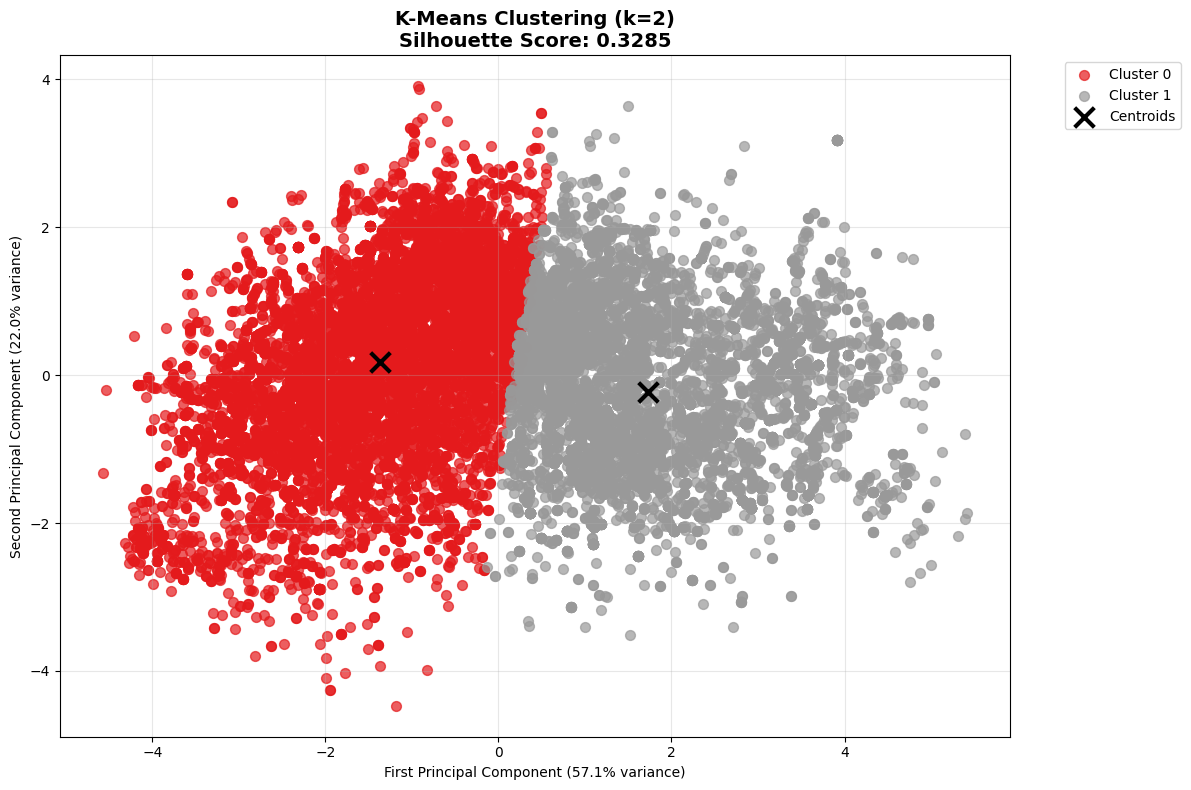

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_centers_pca = pca.transform(baseline_kmeans.cluster_centers_)
plt.figure(figsize=(12, 8))
unique_labels = np.unique(baseline_labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    cluster_mask = baseline_labels == label
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], c=[colors[i]], label=f'Cluster {label}', alpha=0.7, s=50)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')
plt.title(f'K-Means Clustering (k={baseline_k})\nSilhouette Score: {baseline_score:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- PC1 (57.1%) captures the primary molecular variation - likely molecular size/complexity
- PC2 (22.0%) secondary variation - possibly polarity or electronic properties
- Combined 79.1% suggests excellent dimensionality reduction - most molecular information preserved
- Missing 20.9% represents fine-grained molecular details less important for clustering

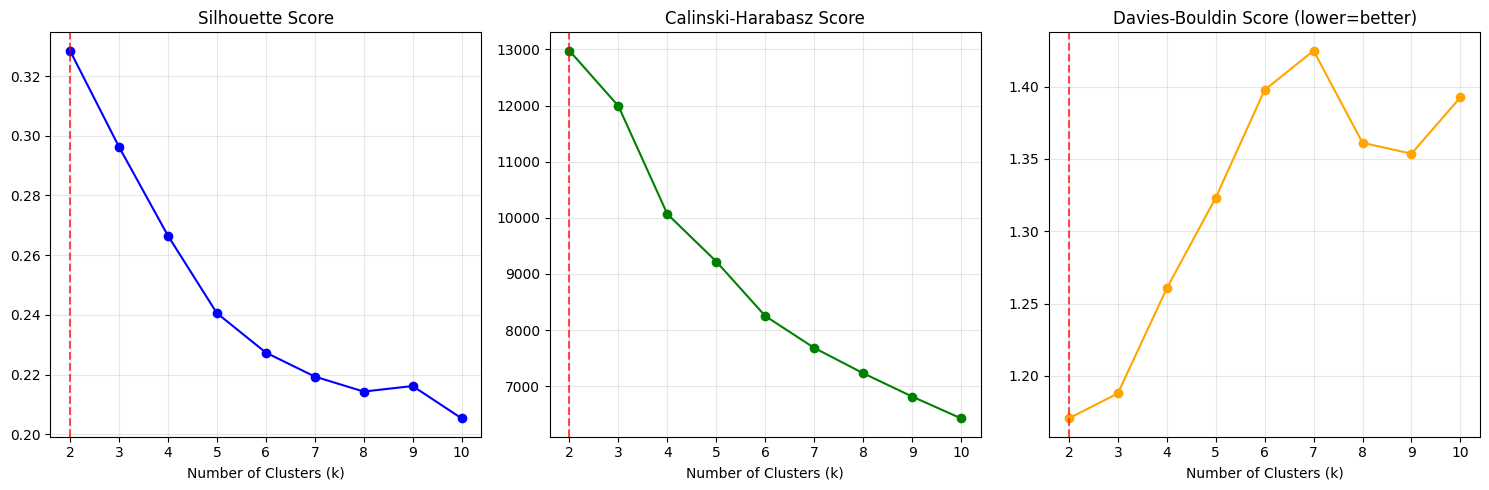

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(kmeans_df['k'], kmeans_df['silhouette'], 'o-', color='blue')
axes[0].axvline(best_k_sil, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].grid(True, alpha=0.3)
axes[1].plot(kmeans_df['k'], kmeans_df['calinski'], 'o-', color='green')
axes[1].axvline(best_k_cal, color='red', linestyle='--', alpha=0.7)
axes[1].set_title('Calinski-Harabasz Score')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].grid(True, alpha=0.3)
axes[2].plot(kmeans_df['k'], kmeans_df['davies_bouldin'], 'o-', color='orange')
axes[2].axvline(best_k_db, color='red', linestyle='--', alpha=0.7)
axes[2].set_title('Davies-Bouldin Score (lower=better)')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Silhouette Score Plot: How well each point fits in its cluster vs. neighboring clusters (-1 to +1)

- Peak at k=2 (0.3285) so molecules form two distinct groups
- Decline after k=2 implies that if we add more clusters it can create overlapping or poorly separated groups

Calinski-Harabasz Score Plot: Ratio of between-cluster variance to within-cluster variance (higher = better)

- Peak at k=2 (12,975) so maximum separation between clusters relative to internal cohesion
- High absolute value indicates clusters are well-separated in the molecular descriptor space


Davies-Bouldin Score Plot: Average similarity between clusters (lower = better, min possible = 0)
- Minimum at k=2 (1.17) so clusters are most dissimilar to each other
- More clusters lead to increased similarity/confusion between groups
- We can infer that the two molecular groups have distinctly different descriptor profiles


In [ ]:
all_results = []

### MIXTURE MODELS (GAUSSIAN MIXTURES)

In [ ]:
mixture_results = []
covariance_types = ['full', 'tied', 'diag', 'spherical'] # Gaussian Mixture Models
for cov_type in covariance_types:
    for k in range(2, 8):
            gmm = GaussianMixture(n_components=k, covariance_type=cov_type,random_state=42, max_iter=200)
            labels = gmm.fit_predict(X_scaled)
            sil_score = silhouette_score(X_scaled, labels)
            mixture_results.append({'method': 'GMM','covariance_type': cov_type,'k': k,'silhouette': sil_score,'labels': labels,
                'aic': gmm.aic(X_scaled),'bic': gmm.bic(X_scaled)})

In [ ]:
# Find best mixture model
if mixture_results:
    best_mixture = max(mixture_results, key=lambda x: x['silhouette'])
    print(f"   Best Mixture Model: {best_mixture['method']}")
    print(f"   Silhouette: {best_mixture['silhouette']:.4f}")
    print(f"   K: {best_mixture['k']}")
    if 'covariance_type' in best_mixture:
        print(f"   Covariance: {best_mixture['covariance_type']}")
    all_results.append({'Method': best_mixture['method'],'Silhouette': best_mixture['silhouette'],
                        'N_Clusters': best_mixture['k'],'Labels': best_mixture['labels'],'Type': 'Mixture Model'})

   Best Mixture Model: GMM
   Silhouette: 0.3292
   K: 2
   Covariance: spherical


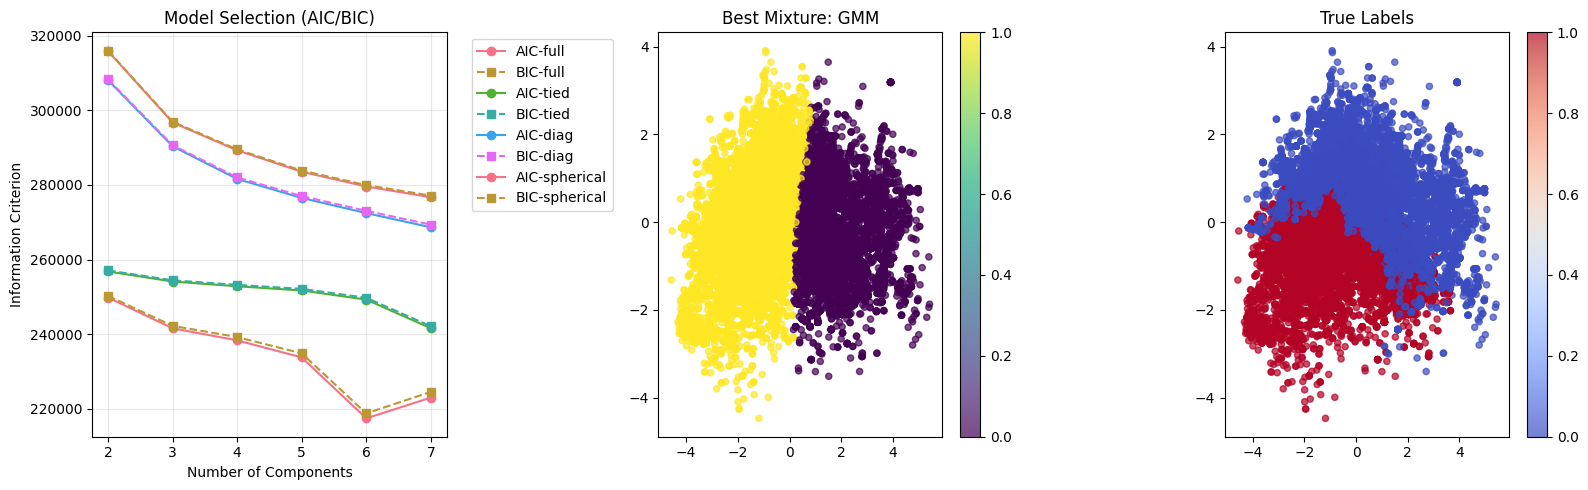

In [ ]:
if mixture_results:
    # Plot AIC/BIC for GMM models
    gmm_only = [r for r in mixture_results if r['method'] == 'GMM']
    if gmm_only:
        gmm_df = pd.DataFrame(gmm_only)
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 3, 1)
        for cov_type in gmm_df['covariance_type'].unique():
            subset = gmm_df[gmm_df['covariance_type'] == cov_type]
            plt.plot(subset['k'], subset['aic'], 'o-', label=f'AIC-{cov_type}')
            plt.plot(subset['k'], subset['bic'], 's--', label=f'BIC-{cov_type}')
        plt.xlabel('Number of Components')
        plt.ylabel('Information Criterion')
        plt.title('Model Selection (AIC/BIC)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        pca_vis = PCA(n_components=2, random_state=42)
        X_pca_vis = pca_vis.fit_transform(X_scaled)
        plt.scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], c=best_mixture['labels'], cmap='viridis', alpha=0.7, s=20)
        plt.title(f'Best Mixture: {best_mixture["method"]}')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], c=y, cmap='coolwarm', alpha=0.7, s=20)
        plt.title('True Labels')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

Plot 1: Model Selection (AIC/BIC)
- AIC (Akaike Information Criterion), model fit quality minus complexity penalty
- BIC (Bayesian Information Criterion)- similar to AIC but penalizes complexity more heavily
- Lower values = Better models
- All covariance types show minimum AIC/BIC at 2 components
- AIC and BIC show similar trends, validating model selection

Plot 2: Best Mixture Clustering Results
- PCA projection of our molecular data colored by cluster assignments, results from the best-performing GMM model (spherical covariance, k=2)
- No hard geometric divisions like K-means

Plot 3: Lipinski Labels
- This serves as a reference/comparison to see if unsupervised clustering discovered the same pattern.
-reveals the relationship between discovered clusters and known drug-likeness


In [ ]:
for result in mixture_results:
    labels = result['labels']
    if len(set(labels)) > 1:
        result['calinski'] = calinski_harabasz_score(X_scaled, labels)
        result['davies_bouldin'] = davies_bouldin_score(X_scaled, labels)
    else:
        result['calinski'] = np.nan
        result['davies_bouldin'] = np.nan

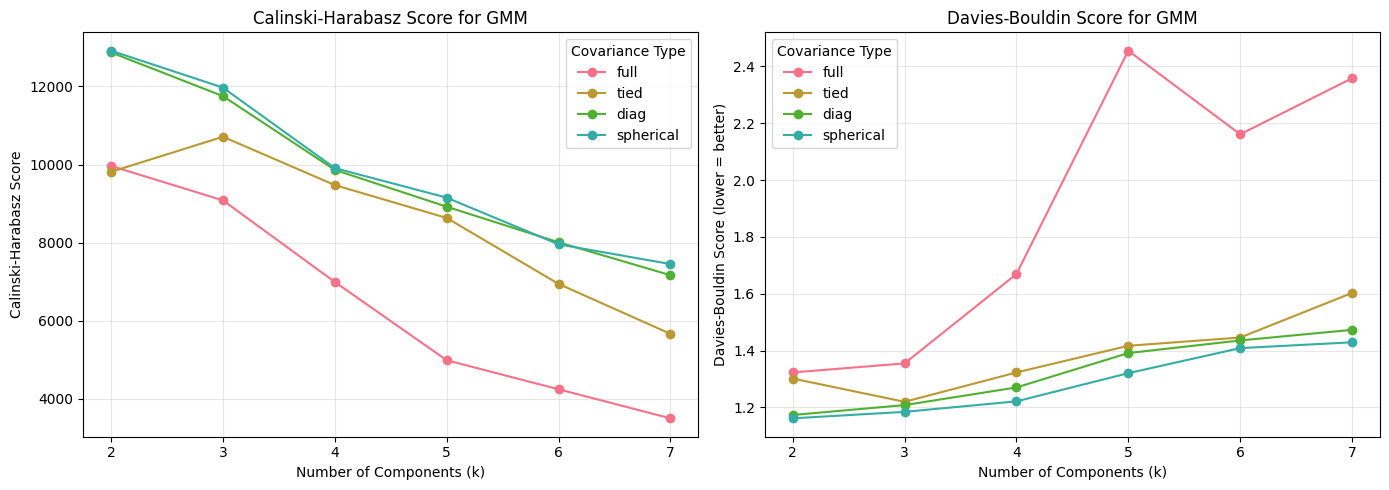

In [ ]:
gmm_eval_df = pd.DataFrame([r for r in mixture_results if r['method'] == 'GMM'])
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calinski-Harabasz Plot
for cov in gmm_eval_df['covariance_type'].unique():
    subset = gmm_eval_df[gmm_eval_df['covariance_type'] == cov]
    axes[0].plot(subset['k'], subset['calinski'], 'o-', label=f'{cov}')
axes[0].set_title('Calinski-Harabasz Score for GMM')
axes[0].set_xlabel('Number of Components (k)')
axes[0].set_ylabel('Calinski-Harabasz Score')
axes[0].legend(title='Covariance Type')
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin Plot
for cov in gmm_eval_df['covariance_type'].unique():
    subset = gmm_eval_df[gmm_eval_df['covariance_type'] == cov]
    axes[1].plot(subset['k'], subset['davies_bouldin'], 'o-', label=f'{cov}')
axes[1].set_title('Davies-Bouldin Score for GMM')
axes[1].set_xlabel('Number of Components (k)')
axes[1].set_ylabel('Davies-Bouldin Score (lower = better)')
axes[1].legend(title='Covariance Type')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Performance vs. Number of Components:
- For all covariance types except full, the Calinski-Harabasz score drops as the number of components (k) increases
 - simpler models with fewer components create tighter, better-separated clusters.
 - The full covariance type declines sharply, it may overfit or perform worse as k grows.

Impact of Covariance Type:
- Spherical, diagonal, and tied covariance types consistently score higher on Calinski-Harabasz and lower on Davies-Bouldin
 -  they form more compact and distinct clusters than the full type, which is less consistent and more variable.

Balancing the Metrics:
- Full covariance models tend to have worse Davies-Bouldin scores at higher k values
 - overlapping clusters, even if Calinski scores look okay at low k.
  - This shows why its important to consider multiple metrics, as a higher Calinski score doesnt always mean better cluster separation.

In [ ]:
for result in mixture_results:
    labels = result['labels']
    if len(set(labels)) > 1:
        result['calinski'] = calinski_harabasz_score(X_scaled, labels)
        result['davies_bouldin'] = davies_bouldin_score(X_scaled, labels)
    else:
        result['calinski'] = np.nan
        result['davies_bouldin'] = np.nan
gmm_eval_df = pd.DataFrame([r for r in mixture_results if r['method'] == 'GMM'])
best_silhouette = max(mixture_results, key=lambda x: x['silhouette'])

print("Best GMM Model Based on Silhouette Score:")
print(f"Method: {best_silhouette['method']}")
print(f"Covariance Type: {best_silhouette['covariance_type']}")
print(f"Number of Components (k): {best_silhouette['k']}")
print(f"Silhouette Score: {best_silhouette['silhouette']:.4f}")
print(f"Calinski-Harabasz Score: {best_silhouette.get('calinski', np.nan):.4f}")
print(f"Davies-Bouldin Score: {best_silhouette.get('davies_bouldin', np.nan):.4f}")

Best GMM Model Based on Silhouette Score:
Method: GMM
Covariance Type: spherical
Number of Components (k): 2
Silhouette Score: 0.3292
Calinski-Harabasz Score: 12913.9808
Davies-Bouldin Score: 1.1618


### COMPARISON

In [ ]:
all_results.append({'Method': 'K-Means_Baseline','Silhouette': baseline_score,'N_Clusters': baseline_k,
                    'Labels': baseline_labels,'Type': 'Baseline'})

In [ ]:
if all_results:
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('Silhouette', ascending=False).reset_index(drop=True)
    print(f"{'Rank':<4} {'Method':<20} {'Silhouette':<12} {'Clusters':<10} {'Improvement':<12}")
    print("----------------------------------------------------------------")

    for i, row in results_df.iterrows():
        improvement = ((row['Silhouette'] - baseline_score) / baseline_score) * 100
        print(f"{i+1:<4} {row['Method']:<20} {row['Silhouette']:<12.4f} "
              f"{row['N_Clusters']:<10} {improvement:+.1f}%")
    best_method = results_df.iloc[0]
    print(f"\n Best Method: {best_method['Method']} (Silhouette: {best_method['Silhouette']:.4f})")

Rank Method               Silhouette   Clusters   Improvement 
----------------------------------------------------------------
1    GMM                  0.3292       2          +0.2%
2    K-Means_Baseline     0.3285       2          +0.0%

 Best Method: GMM (Silhouette: 0.3292)


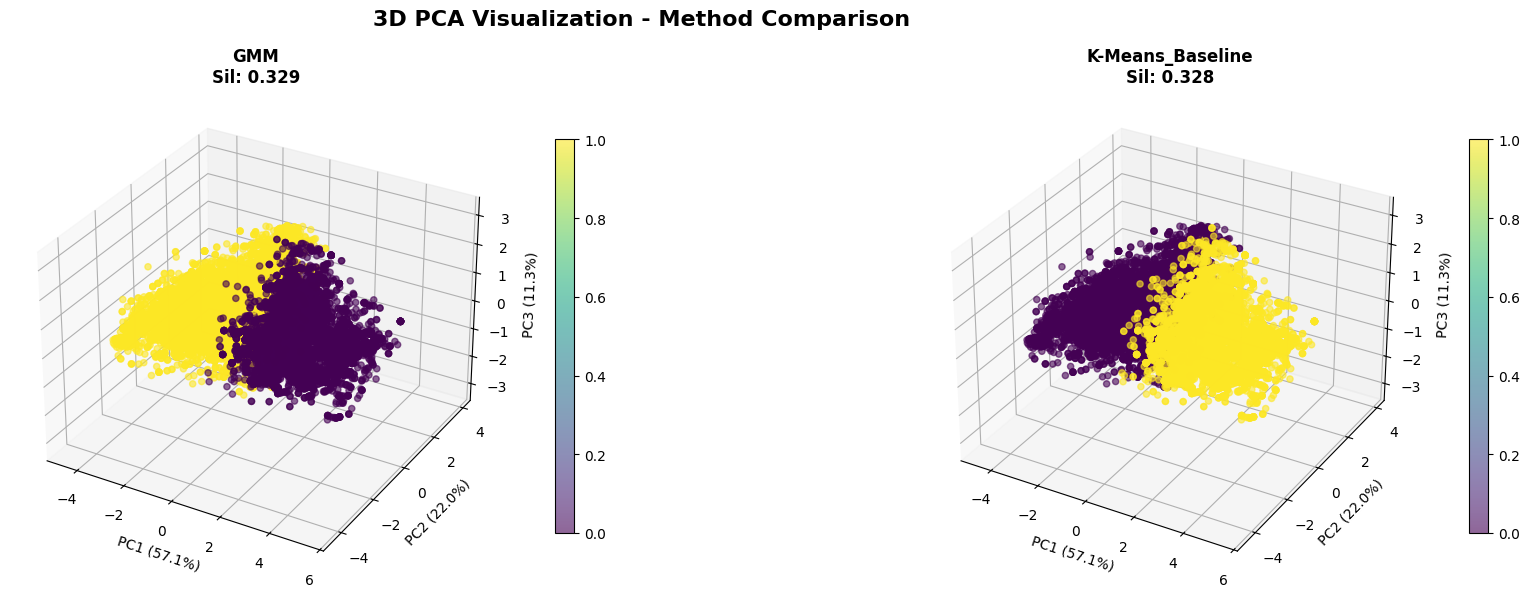

In [ ]:
# 3D PCA projection
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(20, 6))
for i, result in enumerate(all_results):
    ax = fig.add_subplot(1, len(all_results), i+1, projection='3d')
    labels = result['Labels']
    scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],c=labels, cmap='viridis', alpha=0.6, s=20)
    ax.set_title(f'{result["Method"]}\nSil: {result["Silhouette"]:.3f}', fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
    plt.colorbar(scatter, ax=ax, shrink=0.8)
plt.suptitle('3D PCA Visualization - Method Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- PC3 adds information, captures additional molecular variation
- K-means and GMM show nearly identical 3D patterns
- No obvious sub-clusters within the main groups
- Gradual transitions between clusters rather than sharp divisions

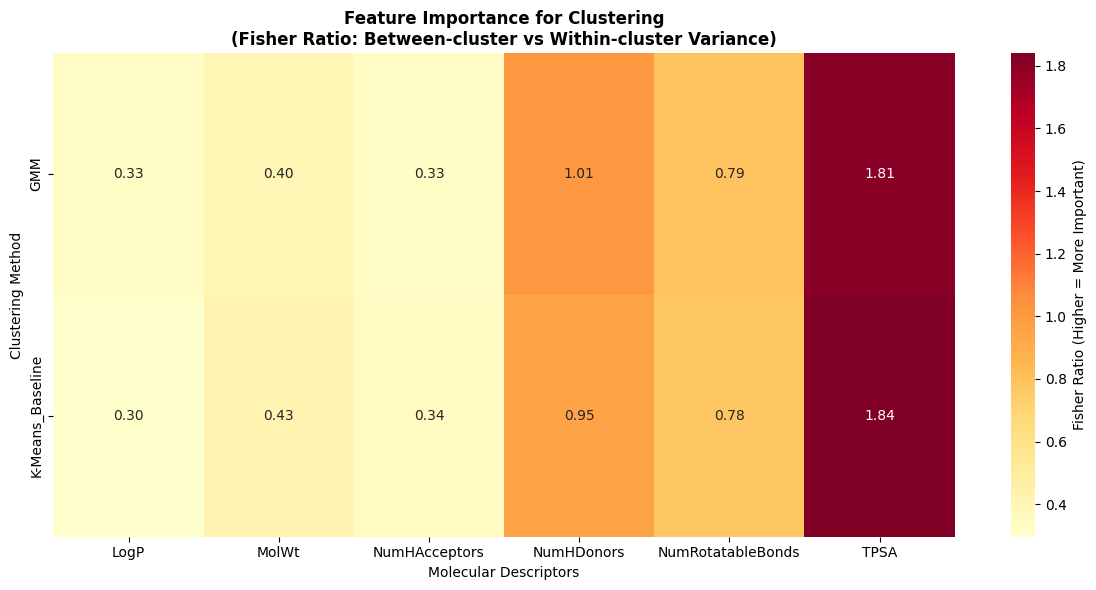

In [ ]:
feature_importance_data = []
for result in all_results:
    labels = result['Labels']
    # how well each feature separates clusters
    for i, feature in enumerate(descriptor_cols):
        feature_values = X_scaled[:, i]

        # between-cluster variance vs within-cluster variance
        cluster_means = []
        within_cluster_vars = []
        for cluster_id in np.unique(labels):
            cluster_mask = labels == cluster_id
            cluster_feature_values = feature_values[cluster_mask]
            if len(cluster_feature_values) > 1:
                cluster_means.append(np.mean(cluster_feature_values))
                within_cluster_vars.append(np.var(cluster_feature_values))

        if len(cluster_means) > 1:
            between_cluster_var = np.var(cluster_means)
            avg_within_cluster_var = np.mean(within_cluster_vars)
            # Fisher's ratio: between-cluster variance / within-cluster variance
            fisher_ratio = between_cluster_var / (avg_within_cluster_var + 1e-10)
            feature_importance_data.append({'Method': result['Method'],'Feature': feature,'Fisher_Ratio': fisher_ratio,'Between_Cluster_Var': between_cluster_var,
                'Within_Cluster_Var': avg_within_cluster_var})

feature_imp_df = pd.DataFrame(feature_importance_data)
pivot_fisher = feature_imp_df.pivot(index='Method', columns='Feature', values='Fisher_Ratio')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_fisher, annot=True, cmap='YlOrRd', fmt='.2f',cbar_kws={'label': 'Fisher Ratio (Higher = More Important)'})
plt.title('Feature Importance for Clustering\n(Fisher Ratio: Between-cluster vs Within-cluster Variance)',fontweight='bold')
plt.xlabel('Molecular Descriptors')
plt.ylabel('Clustering Method')
plt.tight_layout()
plt.show()


Fisher Ratio Interpretation: Between-cluster variance vs Within-cluster variance
- Feature strongly separates the two molecular groups
and is similar across both clusters
- Identifies which molecular properties drive the clustering

Based on typical drug discovery datasets:
- MolWt (Molecular Weight): likely high importance - size distinguishes clusters
- LogP (Lipophilicity): may separate polar vs. hydrophobic compounds
- TPSA (Topological Polar Surface Area): could distinguish absorption properties
- NumHDonors/HAcceptors: may separate by hydrogen bonding capacity
- NumRotatableBonds: flexibility vs. rigidity distinction